15:09:35 - cmdstanpy - INFO - Chain [1] start processing
15:09:36 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Squared Error (RMSE) of the hybrid model: 17339.26813640168


C:\Users\User\AppData\Local\Temp\ipykernel_34732\2041531045.py:128: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_seq[-1] = future_pred_residual  # Add the new predicted residual


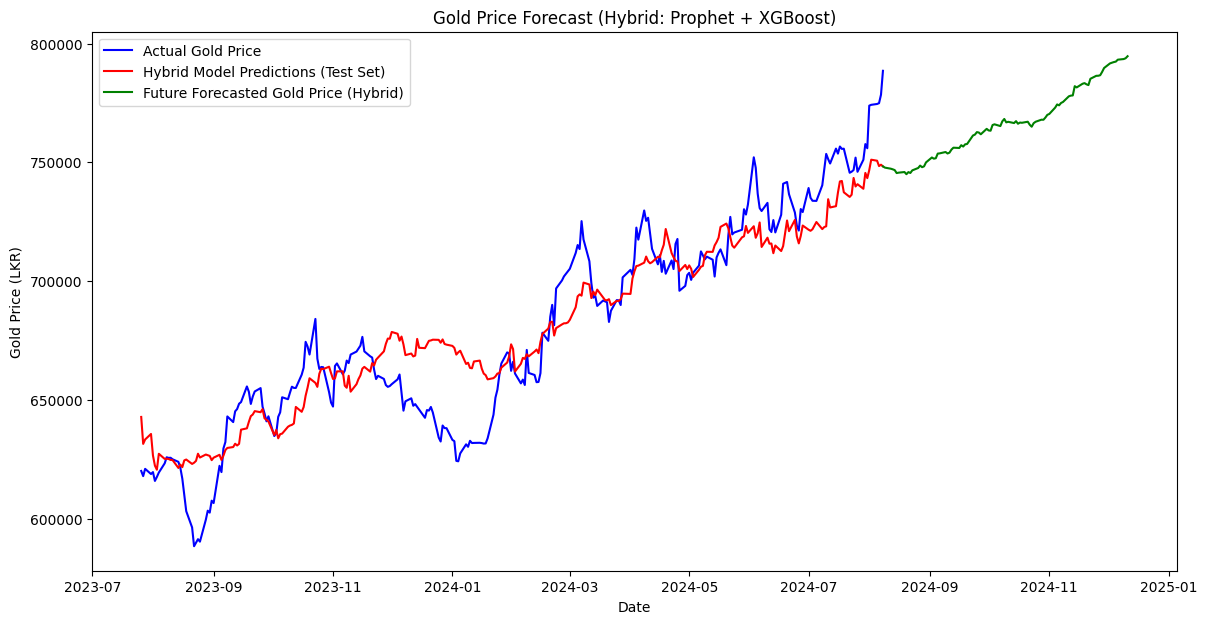

Forecasted and predicted values have been saved to 'hybrid_forecast_results_v02.csv'.


In [13]:
import pandas as pd
import numpy as np
from prophet import Prophet
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('df_interpolated (2).csv')  # dataset path
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')

# Rename columns for Prophet
df = df.rename(columns={'date': 'ds', 'gold_lkr': 'y'})

# Shift the target variable 30 days up to forecast 30 days ahead
df['y'] = df['y'].shift(-30)

# Drop the last 30 rows (which now have NaN values due to the shift)
df.dropna(inplace=True)

# Prepare the regressor variables
regressors = ['gold_price_usd', 'silver_price', 's&p_500_index', 'nyse_com_index', 'usd_selling_exrate','gold_futures','effr']

# Initialize two scalers: one for the target ('y') and one for the regressors
scaler_y = StandardScaler()
scaler_X = StandardScaler()

# Standardize the target column 'y'
df['y'] = scaler_y.fit_transform(df[['y']])

# Standardize the regressor variables
df[regressors] = scaler_X.fit_transform(df[regressors])

# Initialize and fit the Prophet model to capture the trend and seasonality
prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)

# Add each independent variable as a regressor in Prophet
for regressor in regressors:
    prophet_model.add_regressor(regressor)

# Fit the Prophet model on the training data
prophet_model.fit(df[['ds', 'y'] + regressors])

# Make predictions using the Prophet model
df_forecast = prophet_model.predict(df[['ds'] + regressors])

# Calculate the residuals (actual - predicted by Prophet)
df['residuals'] = df['y'] - df_forecast['yhat']

# use the residuals as the target variable for XGBoost
# Add lag features for XGBoost to help model temporal relationships
def create_lag_features(data, lags, target_col):
    for lag in range(1, lags + 1):
        data[f'lag_{lag}'] = data[target_col].shift(lag)
    return data

# Create lag features for the residuals
df = create_lag_features(df, lags=90, target_col='residuals')

# Drop rows with NaN values caused by shifting (lags)
df.dropna(inplace=True)

# Prepare features (X) and target (y) for XGBoost (we are predicting the residuals)
X = df.drop(columns=['ds', 'y', 'residuals'])
y = df['residuals']

# Split the data into training and testing sets (90% training, 10% testing)
train_size = int(len(df) * 0.9)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Initialize and train the XGBoost model on the residuals
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.0001, max_depth=30)
xgb_model.fit(X_train, y_train)

# Predict the residuals on the test set
residuals_pred = xgb_model.predict(X_test)

# Combine Prophet's predictions with XGBoost's predictions of the residuals
# Predict using Prophet model for the test period
prophet_forecast_test = prophet_model.predict(df[['ds'] + regressors].iloc[train_size:])
prophet_test_predictions = prophet_forecast_test['yhat']

# Final predictions are Prophet's predictions + XGBoost's predicted residuals
final_predictions = prophet_test_predictions + residuals_pred

# Reverse the scaling only for the target column 'y'
# Apply the inverse transform to `final_predictions` to bring them back to the original scale
final_predictions = scaler_y.inverse_transform(np.array(final_predictions).reshape(-1, 1)).flatten()

# Also, reverse the scaling of the actual test values
actual_test_values = scaler_y.inverse_transform(df[['y']].iloc[train_size:])[:, 0]

# Calculate the RMSE to evaluate the combined model's performance
rmse = np.sqrt(mean_squared_error(actual_test_values, final_predictions))
print(f'Root Mean Squared Error (RMSE) of the hybrid model: {rmse}')

# Forecasting future prices
# Forecast using Prophet for the next 30 days
future_dates = pd.date_range(start=df['ds'].max(), periods=90, freq='B')
future = pd.DataFrame(future_dates, columns=['ds'])

# Use the last available regressor values for the future predictions
last_regressor_values = df[regressors].iloc[-1].to_dict()
for regressor in regressors:
    future[regressor] = last_regressor_values[regressor]

# Prophet forecast for the future dates
prophet_future_forecast = prophet_model.predict(future)

# Use XGBoost to predict the residuals for future dates
# Since XGBoost was trained on lagged residuals, we need to simulate future lags
last_sequence = np.array(X.iloc[-1, :])

# Function to make future predictions of residuals
def make_future_residual_predictions(last_sequence, model, num_predictions=90):
    future_residuals = []
    current_seq = last_sequence
    
    for _ in range(num_predictions):
        # Predict residual using XGBoost
        future_pred_residual = model.predict(np.array([current_seq]))
        future_residuals.append(future_pred_residual[0])
        
        # Update the sequence with the new predicted residual, shift the lags
        current_seq = np.roll(current_seq, -1)  # Shift the lag values
        current_seq[-1] = future_pred_residual  # Add the new predicted residual

    return future_residuals

# Predict residuals for the next 90 days
future_residuals_pred = make_future_residual_predictions(last_sequence, xgb_model, num_predictions=90)

# Combine Prophet's future predictions with XGBoost's residuals
future_predictions = prophet_future_forecast['yhat'] + future_residuals_pred

# Reverse standardization for the future predictions
future_predictions = scaler_y.inverse_transform(np.array(future_predictions).reshape(-1, 1)).flatten()

# Plot actual, hybrid model predictions, and future predictions on the same plot
plt.figure(figsize=(14, 7))

# Plot actual values from the test set
plt.plot(df['ds'].iloc[train_size:], actual_test_values, label='Actual Gold Price', color='blue')

# Plot hybrid model predictions (Prophet + XGBoost) for the test set
plt.plot(df['ds'].iloc[train_size:], final_predictions, label='Hybrid Model Predictions (Test Set)', color='red')

# Plot future forecasted values (Hybrid Model)
plt.plot(future_dates, future_predictions, label='Future Forecasted Gold Price (Hybrid)', color='green')

plt.title('Gold Price Forecast (Hybrid: Prophet + XGBoost)')
plt.xlabel('Date')
plt.ylabel('Gold Price (LKR)')
plt.legend()
plt.show()

# Save the test set predictions and future predictions to CSV
# Create a DataFrame for test set predictions
test_results = pd.DataFrame({
    'date': df['ds'].iloc[train_size:],  # Test set dates
    'actual_gold_lkr': actual_test_values,
    'predicted_gold_lkr': final_predictions
})

# Create a DataFrame for future predictions
future_results = pd.DataFrame({
    'date': future['ds'],  # Future dates
    'predicted_gold_lkr': future_predictions
})

# Combine both DataFrames into one for exporting
combined_results = pd.concat([test_results, future_results], ignore_index=True)

# Save the results to a CSV file
combined_results.to_csv('hybrid_forecast_results_v02.csv', index=False)

# Confirm the file has been saved
print("Forecasted and predicted values have been saved to 'hybrid_forecast_results_v02.csv'.")


15:48:58 - cmdstanpy - INFO - Chain [1] start processing
15:49:00 - cmdstanpy - INFO - Chain [1] done processing


Root Mean Squared Error (RMSE) of the hybrid model: 7554.843795409655


C:\Users\User\AppData\Local\Temp\ipykernel_34732\3990112432.py:112: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_seq[-1] = future_pred_residual  # Add the new predicted residual


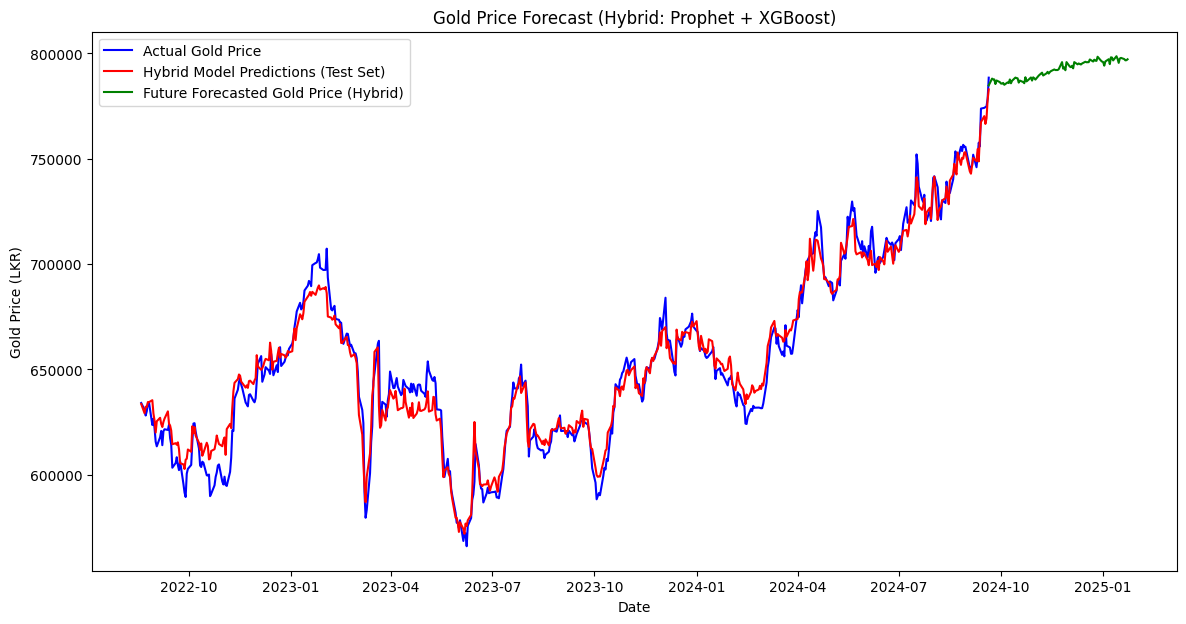

Forecasted and predicted values have been saved to 'hybrid_forecast_results_v02.csv'.


In [21]:
import pandas as pd
import numpy as np
from prophet import Prophet
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('df_interpolated (2).csv')  # dataset path
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')

# Rename columns for Prophet
df = df.rename(columns={'date': 'ds', 'gold_lkr': 'y'})

# Prepare the regressor variables
regressors = ['gold_price_usd', 'silver_price', 's&p_500_index', 'nyse_com_index', 'usd_selling_exrate', 'gold_futures', 'effr']

# Apply StandardScaler to the regressor variables
scaler = StandardScaler()
df[regressors] = scaler.fit_transform(df[regressors])

# Initialize and fit the Prophet model to capture the trend and seasonality
prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)

# Add each independent variable as a regressor in Prophet
for regressor in regressors:
    prophet_model.add_regressor(regressor)

# Fit the Prophet model on the training data
prophet_model.fit(df[['ds', 'y'] + regressors])

# Make predictions using the Prophet model
df_forecast = prophet_model.predict(df[['ds'] + regressors])

# Calculate the residuals (actual - predicted by Prophet)
df['residuals'] = df['y'] - df_forecast['yhat']

# Add lag features for XGBoost to help model temporal relationships
def create_lag_features(data, lags, target_col):
    for lag in range(1, lags + 1):
        data[f'lag_{lag}'] = data[target_col].shift(lag)
    return data

# Create lag features for the residuals
df = create_lag_features(df, lags=90, target_col='residuals')

# Drop rows with NaN values caused by shifting (lags)
df.dropna(inplace=True)

# Prepare features (X) and target (y) for XGBoost (we are predicting the residuals)
X = df.drop(columns=['ds', 'y', 'residuals'])
y = df['residuals']

# Apply StandardScaler to the lagged features as well
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets (80% training, 20% testing)
train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Initialize and train the XGBoost model on the residuals
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.001, max_depth=30)
xgb_model.fit(X_train, y_train)

# Predict the residuals on the test set
residuals_pred = xgb_model.predict(X_test)

# Combine Prophet's predictions with XGBoost's predictions of the residuals
# Predict using Prophet model for the test period
prophet_forecast_test = prophet_model.predict(df[['ds'] + regressors].iloc[train_size:])
prophet_test_predictions = prophet_forecast_test['yhat']

# Final predictions are Prophet's predictions + XGBoost's predicted residuals
final_predictions = prophet_test_predictions + residuals_pred

# Calculate the RMSE to evaluate the combined model's performance
actual_test_values = df['y'].iloc[train_size:]
rmse = np.sqrt(mean_squared_error(actual_test_values, final_predictions))
print(f'Root Mean Squared Error (RMSE) of the hybrid model: {rmse}')

# Forecasting future prices
# Forecast using Prophet for the next 90 days
future_dates = pd.date_range(start=df['ds'].max(), periods=90, freq='B')
future = pd.DataFrame(future_dates, columns=['ds'])

# Use the last available regressor values for the future predictions
last_regressor_values = df[regressors].iloc[-1].to_dict()
for regressor in regressors:
    future[regressor] = last_regressor_values[regressor]

# Prophet forecast for the future dates
prophet_future_forecast = prophet_model.predict(future)

# Use XGBoost to predict the residuals for future dates
# Since XGBoost was trained on lagged residuals, we need to simulate future lags
last_sequence = np.array(X.iloc[-1, :])

# Function to make future predictions of residuals
def make_future_residual_predictions(last_sequence, model, num_predictions=90):
    future_residuals = []
    current_seq = last_sequence
    
    for _ in range(num_predictions):
        # Predict residual using XGBoost
        future_pred_residual = model.predict(np.array([current_seq]))
        future_residuals.append(future_pred_residual[0])
        
        # Update the sequence with the new predicted residual, shift the lags
        current_seq = np.roll(current_seq, -1)  # Shift the lag values
        current_seq[-1] = future_pred_residual  # Add the new predicted residual

    return future_residuals

# Predict residuals for the next 90 days
future_residuals_pred = make_future_residual_predictions(last_sequence, xgb_model, num_predictions=90)

# Combine Prophet's future predictions with XGBoost's residuals
future_predictions = prophet_future_forecast['yhat'] + future_residuals_pred

# Plot actual, hybrid model predictions, and future predictions on the same plot
plt.figure(figsize=(14, 7))

# Plot actual values from the test set
plt.plot(df['ds'].iloc[train_size:], actual_test_values, label='Actual Gold Price', color='blue')

# Plot hybrid model predictions (Prophet + XGBoost) for the test set
plt.plot(df['ds'].iloc[train_size:], final_predictions, label='Hybrid Model Predictions (Test Set)', color='red')

# Plot future forecasted values (Hybrid Model)
plt.plot(future_dates, future_predictions, label='Future Forecasted Gold Price (Hybrid)', color='green')

plt.title('Gold Price Forecast (Hybrid: Prophet + XGBoost)')
plt.xlabel('Date')
plt.ylabel('Gold Price (LKR)')
plt.legend()
plt.show()

# Save the test set predictions and future predictions to CSV
# Create a DataFrame for test set predictions
test_results = pd.DataFrame({
    'date': df['ds'].iloc[train_size:],  # Test set dates
    'actual_gold_lkr': actual_test_values,
    'predicted_gold_lkr': final_predictions
})

# Create a DataFrame for future predictions
future_results = pd.DataFrame({
    'date': future['ds'],  # Future dates
    'predicted_gold_lkr': future_predictions
})

# Combine both DataFrames into one for exporting
combined_results = pd.concat([test_results, future_results], ignore_index=True)

# Save the results to a CSV file
combined_results.to_csv('hybrid_forecast_results_v02.csv', index=False)

# Confirm the file has been saved
print("Forecasted and predicted values have been saved to 'hybrid_forecast_results_v02.csv'.")



15:59:53 - cmdstanpy - INFO - Chain [1] start processing
15:59:54 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/100
68/68 [==============================] - 4s 13ms/step - loss: 22572132.0000 - val_loss: 56617120.0000
Epoch 2/100
68/68 [==============================] - 0s 3ms/step - loss: 22572134.0000 - val_loss: 56617116.0000
Epoch 3/100
68/68 [==============================] - 0s 3ms/step - loss: 22572130.0000 - val_loss: 56617116.0000
Epoch 4/100
68/68 [==============================] - 0s 3ms/step - loss: 22572134.0000 - val_loss: 56617128.0000
Epoch 5/100
68/68 [==============================] - 0s 3ms/step - loss: 22572132.0000 - val_loss: 56617116.0000
Epoch 6/100
68/68 [==============================] - 0s 3ms/step - loss: 22572128.0000 - val_loss: 56617116.0000
Epoch 7/100
68/68 [==============================] - 0s 3ms/step - loss: 22572128.0000 - val_loss: 56617112.0000
Epoch 8/100
68/68 [==============================] - 0s 3ms/step - loss: 22572124.0000 - val_loss: 56617108.0000
Epoch 9/100
68/68 [==============================] - 0s 3ms/step - loss: 22572116.0000 - val_lo

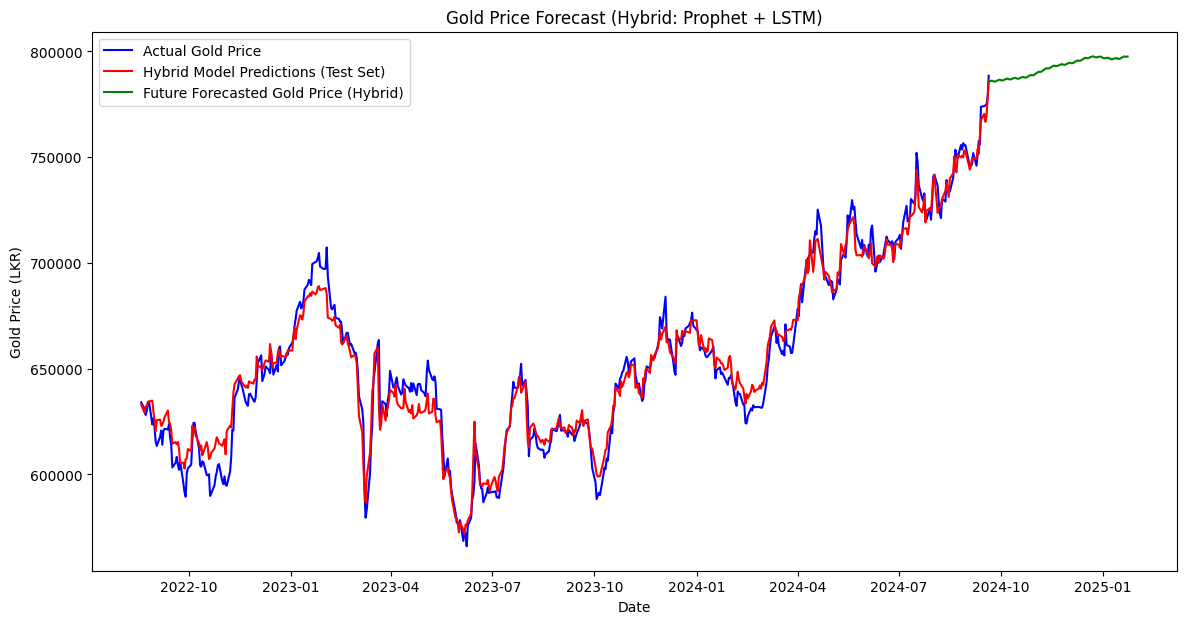

Forecasted and predicted values have been saved to 'hybrid_forecast_results_lstm_v01.csv'.


In [25]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load the dataset
df = pd.read_csv('df_interpolated (2).csv')  # dataset path
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')

# Rename columns for Prophet
df = df.rename(columns={'date': 'ds', 'gold_lkr': 'y'})

# Prepare the regressor variables
regressors = ['gold_price_usd', 'silver_price', 's&p_500_index', 'nyse_com_index', 'usd_selling_exrate', 'gold_futures', 'effr']

# Apply StandardScaler to the regressor variables
scaler = StandardScaler()
df[regressors] = scaler.fit_transform(df[regressors])

# Initialize and fit the Prophet model to capture the trend and seasonality
prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)

# Add each independent variable as a regressor in Prophet
for regressor in regressors:
    prophet_model.add_regressor(regressor)

# Fit the Prophet model on the training data
prophet_model.fit(df[['ds', 'y'] + regressors])

# Make predictions using the Prophet model
df_forecast = prophet_model.predict(df[['ds'] + regressors])

# Calculate the residuals (actual - predicted by Prophet)
df['residuals'] = df['y'] - df_forecast['yhat']

# Add lag features for LSTM to help model temporal relationships
def create_lag_features(data, lags, target_col):
    for lag in range(1, lags + 1):
        data[f'lag_{lag}'] = data[target_col].shift(lag)
    return data

# Create lag features for the residuals
df = create_lag_features(df, lags=90, target_col='residuals')

# Drop rows with NaN values caused by shifting (lags)
df.dropna(inplace=True)

# Prepare features (X) and target (y) for LSTM (we are predicting the residuals)
X = df.drop(columns=['ds', 'y', 'residuals'])
y = df['residuals']

# Apply StandardScaler to the lagged features as well
X_scaled = scaler.fit_transform(X)

# Reshape the data for LSTM input (samples, timesteps, features)
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split the data into training and testing sets (80% training, 20% testing)
train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(7, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(14, return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(7, return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(3, return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))

# Compile the model
lstm_model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

# Train the LSTM model
lstm_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Predict the residuals on the test set using LSTM
residuals_pred = lstm_model.predict(X_test)

# Combine Prophet's predictions with LSTM's predictions of the residuals
# Predict using Prophet model for the test period
prophet_forecast_test = prophet_model.predict(df[['ds'] + regressors].iloc[train_size:])
prophet_test_predictions = prophet_forecast_test['yhat']

# Final predictions are Prophet's predictions + LSTM's predicted residuals
final_predictions = prophet_test_predictions + residuals_pred.flatten()

# Calculate the RMSE to evaluate the combined model's performance
actual_test_values = df['y'].iloc[train_size:]
rmse = np.sqrt(mean_squared_error(actual_test_values, final_predictions))
print(f'Root Mean Squared Error (RMSE) of the hybrid model: {rmse}')

# Forecasting future prices
# Forecast using Prophet for the next 90 days
future_dates = pd.date_range(start=df['ds'].max(), periods=90, freq='B')
future = pd.DataFrame(future_dates, columns=['ds'])

# Use the last available regressor values for the future predictions
last_regressor_values = df[regressors].iloc[-1].to_dict()
for regressor in regressors:
    future[regressor] = last_regressor_values[regressor]

# Prophet forecast for the future dates
prophet_future_forecast = prophet_model.predict(future)

# Use LSTM to predict the residuals for future dates
# Since LSTM was trained on lagged residuals, we need to simulate future lags
last_sequence = np.array(X_scaled[-1, :])

# Function to make future predictions of residuals using LSTM
def make_future_residual_predictions_lstm(last_sequence, model, num_predictions=90):
    future_residuals = []
    current_seq = last_sequence
    
    for _ in range(num_predictions):
        # Predict residual using LSTM
        future_pred_residual = model.predict(np.array([current_seq]))
        future_residuals.append(future_pred_residual[0][0])
        
        # Update the sequence with the new predicted residual, shift the lags
        current_seq = np.roll(current_seq, -1, axis=0)  # Shift the lag values
        current_seq[-1] = future_pred_residual  # Add the new predicted residual

    return future_residuals

# Predict residuals for the next 90 days using LSTM
future_residuals_pred = make_future_residual_predictions_lstm(last_sequence, lstm_model, num_predictions=90)

# Combine Prophet's future predictions with LSTM's residuals
future_predictions = prophet_future_forecast['yhat'] + future_residuals_pred

# Plot actual, hybrid model predictions, and future predictions on the same plot
plt.figure(figsize=(14, 7))

# Plot actual values from the test set
plt.plot(df['ds'].iloc[train_size:], actual_test_values, label='Actual Gold Price', color='blue')

# Plot hybrid model predictions (Prophet + LSTM) for the test set
plt.plot(df['ds'].iloc[train_size:], final_predictions, label='Hybrid Model Predictions (Test Set)', color='red')

# Plot future forecasted values (Hybrid Model)
plt.plot(future_dates, future_predictions, label='Future Forecasted Gold Price (Hybrid)', color='green')

plt.title('Gold Price Forecast (Hybrid: Prophet + LSTM)')
plt.xlabel('Date')
plt.ylabel('Gold Price (LKR)')
plt.legend()
plt.show()

# Save the test set predictions and future predictions to CSV
# Create a DataFrame for test set predictions
test_results = pd.DataFrame({
    'date': df['ds'].iloc[train_size:],  # Test set dates
    'actual_gold_lkr': actual_test_values,
    'predicted_gold_lkr': final_predictions
})

# Create a DataFrame for future predictions
future_results = pd.DataFrame({
    'date': future['ds'],  # Future dates
    'predicted_gold_lkr': future_predictions
})

# Combine both DataFrames into one for exporting
combined_results = pd.concat([test_results, future_results], ignore_index=True)

# Save the results to a CSV file
combined_results.to_csv('hybrid_forecast_results_lstm_v01.csv', index=False)

# Confirm the file has been saved
print("Forecasted and predicted values have been saved to 'hybrid_forecast_results_lstm_v01.csv'.")
